In [11]:
import os 
import tarfile 
import urllib

# Array math
import numpy as np 

# Inspecting functions
import inspect

import time

# Ploting 
import seaborn as sns
import matplotlib.pyplot as plt

# Importing the custom written class 
from DecisionTree import Node 

# Importing the scikit-learn tree implementation
from sklearn.tree import DecisionTreeClassifier

import pandas as pd

csv_path=os.path.join("https://raw.githubusercontent.com/iJovanGG/MachineLearning/master/datasets/income/", "adult.csv")

tree = pd.read_csv(csv_path)
tree.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,yearly-income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [12]:
tree.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,yearly-income
6375,50,Self-emp-not-inc,105010,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,2051,20,United-States,<=50K
20457,60,Private,308608,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,50,United-States,<=50K
5541,33,Private,158416,HS-grad,9,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,40,United-States,<=50K
11137,51,Private,174754,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Female,0,0,38,United-States,<=50K
1576,38,Self-emp-not-inc,257250,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,52,United-States,<=50K
5653,50,Private,96586,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States,<=50K
15201,62,Private,238913,Some-college,10,Married-civ-spouse,Tech-support,Husband,White,Male,2829,0,24,United-States,<=50K
11832,34,Private,339142,HS-grad,9,Separated,Handlers-cleaners,Unmarried,White,Female,0,0,40,United-States,<=50K
20324,65,Private,213477,Masters,14,Divorced,Sales,Not-in-family,White,Male,0,0,28,United-States,<=50K
514,28,Private,189346,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Male,0,0,45,United-States,<=50K


In [13]:
dtree = tree[['yearly-income', 'education', 'workclass', 'sex', 'age', 'hours-per-week']].copy()

# Droping missing entries
dtree.dropna(inplace=True)

In [14]:
print(f"Number of observations: {dtree.shape[0]}")

Number of observations: 32561


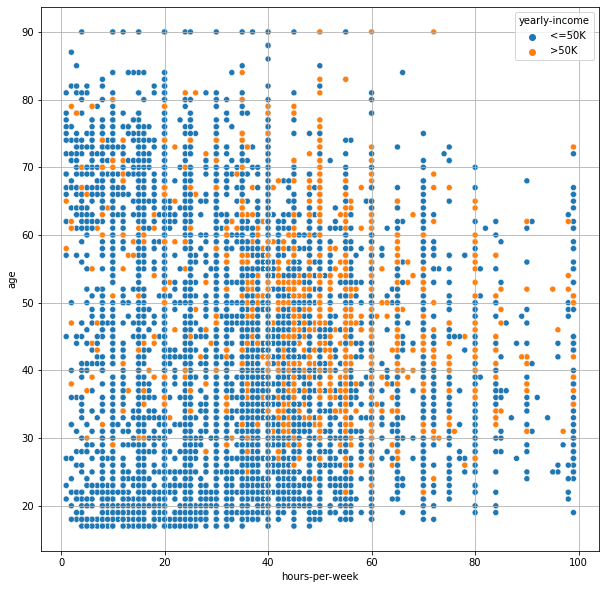

In [15]:
plt.figure(figsize=(10, 10))
sns.scatterplot(y='age', x='hours-per-week', data=dtree, hue='yearly-income')
plt.grid()
plt.show()

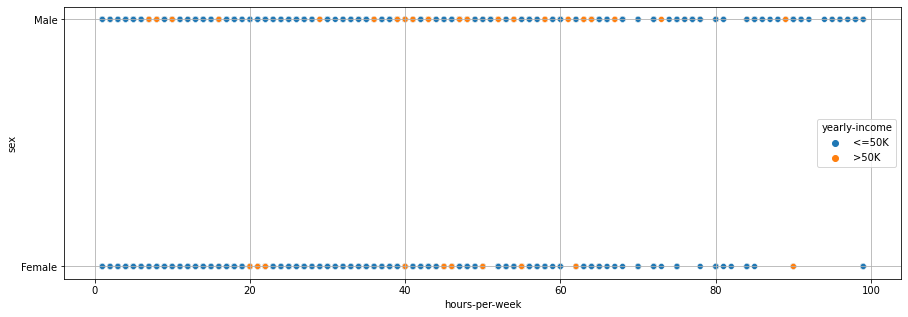

In [16]:
plt.figure(figsize=(15, 5))
sns.scatterplot(y='sex', x='hours-per-week', data=dtree, hue='yearly-income')
plt.grid()
plt.show()

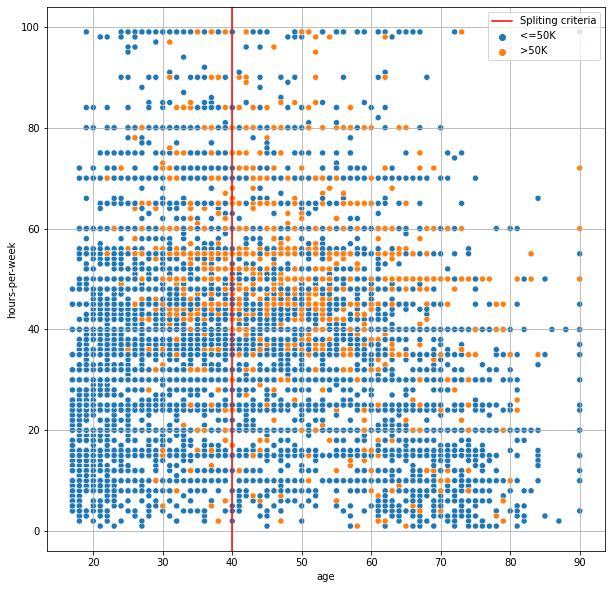

In [17]:
# Define the split value 
age_split = 40

# Ploting the original plot
plt.figure(figsize=(10, 10))
sns.scatterplot(y='hours-per-week', x='age', data=dtree, hue='yearly-income')
plt.grid()

# Adding the vertical line
plt.axvline(age_split, label='Spliting criteria', color='red')
plt.legend()
plt.show()

In [18]:
# Getting the left and right datasets
left = dtree[dtree['age']<=age_split]
right = dtree[dtree['age']>age_split]

In [19]:
print(f"Observations to the left of criteria: {left.shape[0]}")
print(f"Observations to the right of criteria: {right.shape[0]}")

Observations to the left of criteria: 19118
Observations to the right of criteria: 13443


In [20]:
left.groupby('yearly-income', as_index=False).size()

,yearly-income,size
0,<=50K,16030
1,>50K,3088


In [21]:
right.groupby('yearly-income', as_index=False).size()

,yearly-income,size
0,<=50K,8690
1,>50K,4753


In [22]:
print(inspect.getsource(Node.GINI_impurity))

    @staticmethod
    def GINI_impurity(y1_count: int, y2_count: int) -> float:
        """
        Given the observations of a binary class calculate the GINI impurity
        """
        # Ensuring the correct types
        if y1_count is None:
            y1_count = 0

        if y2_count is None:
            y2_count = 0

        # Getting the total observations
        n = y1_count + y2_count
        
        # If n is 0 then we return the lowest possible gini impurity
        if n == 0:
            return 0.0

        # Getting the probability to see each of the classes
        p1 = y1_count / n
        p2 = y2_count / n
        
        # Calculating GINI 
        gini = 1 - (p1 ** 2 + p2 ** 2)
        
        # Returning the gini impurity
        return gini



In [23]:
left_counts = left.groupby("yearly-income").size().values.tolist()
right_counts = right.groupby("yearly-income").size().values.tolist()

gini_left = Node.GINI_impurity(left_counts[0], left_counts[1])
gini_right = Node.GINI_impurity(right_counts[0], right_counts[1])

In [24]:
print(f"Gini impurity of the left node: {gini_left}")
print(f"Gini impurity of the right node: {gini_right}")

Gini impurity of the left node: 0.2708668736515176
Gini impurity of the right node: 0.45711470156401446


In [25]:
w1 = left.shape[0]/ (left.shape[0] + right.shape[0]) 
w2 = right.shape[0] / (left.shape[0] + right.shape[0]) 

In [26]:
gini_final = w1 * gini_left + w2 * gini_right

In [27]:
print(f"Final gini impurity: {gini_final}")

Final gini impurity: 0.3477603827767808


In [28]:
def GINI_impurity_df(df:pd.DataFrame, target):
    """
    Function to calculate the resulting GINI impurity of a split
    """
    # Getting the counts and ginis
    counts = df.groupby(target).size().values.tolist()

    gini = Node.GINI_impurity(counts[0], counts[1])
    
    return gini

In [29]:
gini_orig = GINI_impurity_df(dtree, 'yearly-income')

In [30]:
print(f"Gini non-splited: {gini_orig}")
print(f"Gini with the proposed split: {gini_final}")
print(f"Gini gain: {gini_orig - gini_final}")

Gini non-splited: 0.3656406289773486
Gini with the proposed split: 0.3477603827767808
Gini gain: 0.01788024620056783


In [31]:
print(inspect.getsource(Node.ma))

    @staticmethod
    def ma(x: np.array, window: int) -> np.array:
        """
        Calculates the moving average of the given list. 
        """
        return np.convolve(x, np.ones(window), 'valid') / window



In [32]:
print(inspect.getsource(Node.best_split))

    def best_split(self) -> tuple:
        """
        Given the X features and Y targets calculates the best split 
        for a decision tree
        """
        # Creating a dataset for spliting
        df = self.X.copy()
        df['Y'] = self.Y

        # Getting the GINI impurity for the base input 
        GINI_base = self.get_GINI()

        # Finding which split yields the best GINI gain 
        max_gain = 0

        # Default best feature and split
        best_feature = None
        best_value = None

        for feature in self.features:
            # Droping missing values
            Xdf = df.dropna().sort_values(feature)

            # Sorting the values and getting the rolling average
            xmeans = self.ma(Xdf[feature].unique(), 2)

            for value in xmeans:
                # Spliting the dataset 
                left_counts = Counter(Xdf[Xdf[feature]<value]['Y'])
                right_counts = Counter(Xdf[Xdf[feature]>=value]['Y'])

                # Ge

In [55]:
# Dropping missing values
ddtree = tree[['yearly-income', 'age', 'hours-per-week']].dropna().copy()
ddtree['yearly-income']=ddtree['yearly-income'].replace('>50K','1')
ddtree['yearly-income']=ddtree['yearly-income'].replace('<=50K','0')
ddtree['yearly-income']=ddtree['yearly-income'].astype('int')
# Defining the X and Y matrices
Y = ddtree['yearly-income'].values
print(Y)

X = ddtree[['age', 'hours-per-week']]
print(X)

# Saving the feature list 
features = list(X.columns)

[0 0 0 ... 0 0 1]
       age  hours-per-week
0       39              40
1       50              13
2       38              40
3       53              40
4       28              40
...    ...             ...
32556   27              38
32557   40              40
32558   58              40
32559   22              20
32560   52              40

[32561 rows x 2 columns]


In [56]:
# Setting the available hyper parameters of a tree
hp = {
    'max_depth': 10,
    'min_samples_split': 5
}
print(hp)

{'max_depth': 10, 'min_samples_split': 5}


In [57]:
# Initiating the Node
root = Node(Y, X, **hp)

# Getting teh best split
root.grow_tree()

# Printing the tree information 
root.print_tree()

Root
   | GINI impurity of the node: 0.37
   | Class distribution in the node: {0: 24720, 1: 7841}
   | Predicted class: 0
|-------- Split rule: age <= 29.5
           | GINI impurity of the node: 0.1
           | Class distribution in the node: {0: 9200, 1: 511}
           | Predicted class: 0
|---------------- Split rule: age <= 25.5
                   | GINI impurity of the node: 0.03
                   | Class distribution in the node: {0: 6297, 1: 114}
                   | Predicted class: 0
|------------------------ Split rule: age <= 23.5
                           | GINI impurity of the node: 0.01
                           | Class distribution in the node: {0: 4742, 1: 30}
                           | Predicted class: 0
|-------------------------------- Split rule: hours-per-week <= 45.5
                                   | GINI impurity of the node: 0.01
                                   | Class distribution in the node: {0: 4405, 1: 18}
                                   | 

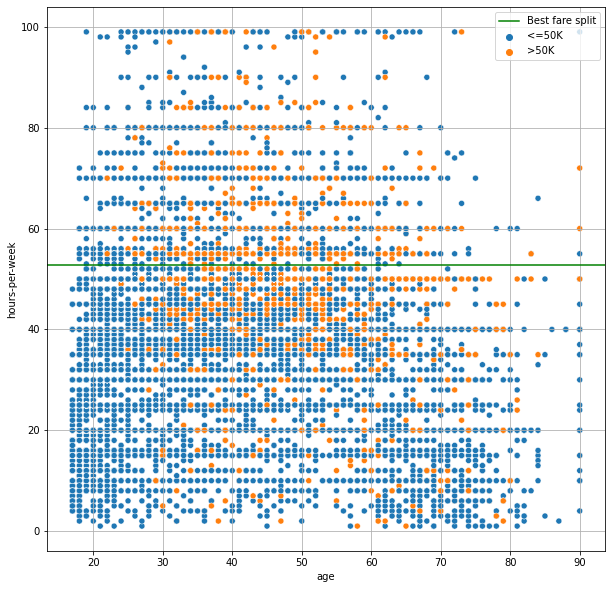

In [65]:
# Define the split value 
#age_split = 25 

# Ploting the original plot
plt.figure(figsize=(10, 10))
sns.scatterplot(y='hours-per-week', x='age', data=dtree, hue='yearly-income')
plt.grid()

# Adding the split line
plt.axhline(52.77, label='Best fare split', color='green')
plt.legend()
plt.show()

In [59]:
custom_tree_start = time.time()

# Initiating the Node
root = Node(Y, X, **hp)

# Getting teh best split
root.grow_tree()

custom_tree_time = time.time() - custom_tree_start
print(custom_tree_time)

45.395949363708496


In [60]:
scikit_tree_start = time.time()

# Using the ML package 
clf = DecisionTreeClassifier(**hp)
clf.fit(X, Y)

scikit_tree_time = time.time() - scikit_tree_start

In [61]:
print(f"Custom tree growing time: {custom_tree_time}s")
print(f"Scikit tree growing time: {scikit_tree_time}s")

Custom tree growing time: 45.395949363708496s
Scikit tree growing time: 0.10793137550354004s
